In [12]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

# animations, etc. requires below magic command
# %matplotlib notebook


"""
Load relevant packages
"""

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import animation, cm

from scipy import stats
from scipy import optimize
from scipy.optimize import minimize
from functools import reduce


import autograd
from statsmodels.tools.numdiff import approx_fprime, approx_hess

"""
Own packages
"""

from codelib.visualization.layout import DefaultStyle
DefaultStyle();

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction to fixed income modelling 

__Note__: For further details the reader is referred to [Claus Munk (2013), "Fixed income modelling"](https://www.amazon.co.uk/Fixed-Income-Modelling-Claus-Munk/dp/0198716443)

The term [_fixed income_](https://www.investopedia.com/terms/f/fixedincome.asp) refers to assets and securities that pay out a set level of cash flows to investors, typically in the form of fixed interest or dividends. The simplest fixed income instruments are bonds that we can think of as a tradable loan agreement. 

We will in this lecture note introduce some terminology and see how we can extract yield curves from observed bond prices. The yield captures the infomation we need to price of fixed income instruments.   

## Some terminology 

### Bond types

__Zero-coupon bond - the fundamental building-block__

A zero coupon bond is the simplest type of bond. A coupon bond at time $t$ promises a single payment (we assume 1 if not otherwise stated) at time $T \geq t$ and has the price $B_t^T$. Note that $B_t^t = 1$. The zero coupon bond represents the market discount factor for a sure time $T$ payment. 

__Coupon bonds__

A _coupon bond_ has multiple payments $Y_i, \; i = 1, ...,n$ for different payments dates $T_i = T_1, ..., T_n$. We can think of a coupon bond as a portfolio of zero coupon bonds. Thus, if we can obtain the zero coupon term structure, we can price any coupon bond (or fixed cash flow). The price of a bond can be written as

$$
B_t = \sum_{T_i > t} Y_i B_t^{T_i}
$$

Typically, coupon bonds have fixed payment intervals, e.g. $\delta \in  [0.25, 0.5, 1.0]$ corresponding to quarterly, semi-annually, and yearly. The size of payments is determined by the face value, coupon rate and amortization principle.  The coupon rate $R$ is typically qouted annually such that the periodic coupon rate is $\delta R$. 

Three examples of coupon bonds are

* Bullet bonds
* Annuity bonds
* Serial bonds

_Bullet bonds_ pays the periodic coupon rate times the face value for all payment dates expect for the last payment where the face value also is repaid. E.g a 5-year bullet bond with coupon rate $R$ and face value of $1$: 

$$
Y_i = \left \{ \begin{array}{ll} R, & i = 1, ..., 4\\ 1 + R, & i=5 \end{array} \right. 
$$

_Annuity bonds_ have equal payments for all payments dates. Each payment is composed of an interest payment and a principle repayment. A $n$-year annuity with annual payments will have the payments

$$
Y_i = Y = \frac{R}{1 - (1+R)^{-n}}
$$

_Serial bonds_ pays the face value back in equal installments. A $n$ year bond with annual payments 

$$
Y_i = \frac{1}{n} + R(1 - \frac{i-1}{n})
$$


### Yields and zero-coupon rates

The _yield_ of a bond, $\hat{y}_t^B$ (annually compounded) or $y_t^B$ (continuous compounding),  is the discount rate for which the present value of the future payments discounted at that rate is equal to the current price of the bond. The annually compuounded yield

$$
B_t = \sum_{T_i > t} Y_i \left(1 +  \hat{y}_t^B\right)^{-(T_i - t)}
$$

and the continuous compounded yield 

$$
B_t = \sum_{T_i > t} Y_i e^{-y_t^B (T_i - t)}
$$


We will often be interested in the zero-coupon yields that convey the same information as the discounter factor and thereby usefull for pricing other fixed income sercurites. Again, the _annually compounded_ zero-coupon yield is 
$$
B_t^T =  \left(1 +  \hat{y}_t^T\right)^{-(T - t)}
$$
Solving for the yield gives us 

$$
\hat{y}_t^T = \left(B_t^T \right)^{- \frac{1}{T-t}} - 1
$$

For the case with _continuous compounding_ we have 
$$
B_t^T = e^{-y_t^T (T - t)}
$$
and the corresponding zero-coupon yield 
$$
y_t^T = - \frac{1}{T-t}\ln B_t^T
$$

Our goal will be to find a zero-coupon yield curve such that we can price a range of fixed income instruments. 

### Forward rates

The _forward rate_ reflects the price on a loan between two future dates. The _annually compounded_ forward rate between time $T$ and $S$ is given by 

$$
\hat{f}_t^{T,S} = \left(\frac{B_t^T}{B_t^S} \right)^{1/(S-T)} - 1
$$
such that 
$$
\left(1 +  \hat{y}_t^S\right)^{-(S-t)} = \left(1 + \hat{y}_t^T \right)^{-(T-t)} \left(1 + \hat{f}_t^{T,S}  \right)^{-(S-T)}
$$
Similarly, with _continuous compounding_ we have 
$$
f_t^{T,S} = - \frac{\ln B_t^S - \ln B_t^T}{S-T}
$$
such that 
$$
B_t^S = B_t^T e^{-f_t^{T,S}(S-T)}
$$
We obtain the instantaneous forward rate as the limit when $S \to T$
$$
f_t^T = \frac{\partial \ln B_t^T}{\partial T} = - \frac{\partial B_t^T}{\partial T} \frac{1}{B_t^T}
$$
The zero-coupon yield is related to the instantaneous forward rates as follows
$$
y_t^T = \frac{1}{T-t}\intop_t^T f_t^u du
$$
such that 
$$
B_t^T = e^{-\intop_t^T f_t^u du}
$$

## Extracting yield curves from bond prices


### Bootstrapping

Boostrapping is the simplest way of obtaining zero-coupon yields. If we observe coupon bonds then we will be able to back-out the implicit zero-coupon yields consistent witht the observed market prices. Assume that we have the two bonds and we are standing at time $t=0$

|| Cash Flow, $t=1$| Cash Flow, $t=2$| Price  |
|:----------|||----------|
| Bond 1    | 110|   | 100.0  |
| Bond 2    |5 | 105    | 90.0  |


Then clearly, the discount factor (the price of a zero-coupon bond) maturing at time $t=1$ is 
$$
100 = 110 B_0^1 \Rightarrow B_0^1 = \frac{1}{110} 100 
$$
and 
$$
90 = 5 B_0^1 + 105 B_0^2 = 5 \frac{1}{110} 100 + 105 B_0^2  \Rightarrow B_0^2 = \frac{1}{105} 90 +  \frac{5}{105}  \frac{1}{110} 100
$$

In [13]:
cf_matrix = np.array([[110.0, 0.0],
                      [5.0, 105.0]])
price_vector = np.array([100.0, 90.0])

# discount factors
discount_factors = np.linalg.inv(cf_matrix)@price_vector
discount_factors

array([0.90909091, 0.81385281])

In [14]:
# zero yields
zero_yields = -np.log(discount_factors)/np.array([1.0, 2.0])
zero_yields

array([0.09531018, 0.10298787])

The example above shows us that we basically need to solve a system of equations 
$$
\mathbf{B}_t = \begin{bmatrix} B_{1,t} \\ B_{2, t} \\  \vdots \\ B_{m, t} \end{bmatrix}  = 
\begin{bmatrix} Y_{1,1} & Y_{1,2} & \dots & Y_{1, n} \\ 
Y_{2, 1} & Y_{2,2} & \dots & Y_{2, n}\\  
\vdots & \vdots & \ddots & \vdots \\
Y_{m, 1} & Y_{m, 2} & \dots & Y_{m, n}  \end{bmatrix} 
\begin{bmatrix} B_{t}^{T_1} \\ B_t^{T_2} \\  \vdots \\ B_t^{T_n} \end{bmatrix} = \mathbf{C}_t  \mathbf{Z}_t
$$
where we have $m$ different bonds with $n$ different payment dates - note that some payments may be zero. Given the cash flows and observed bond prices, we can solve of a unique discount vector $\mathbf{Z}_t$
$$
Z_t = \mathbf{C}^{-1} \mathbf{B}_t
$$
if the cash flow matrix $\mathbf{C}_t$ is invertible (non-singular). If $m>n$ the system of equation may not have any solutions and if $m<n$ then we may have multiple solutions. 


__Example__

__Note__: Example is adapted from _Exercise 2.2_ in [Claus Munk (2013), "Fixed income modelling"](https://www.amazon.co.uk/Fixed-Income-Modelling-Claus-Munk/dp/0198716443)

Consider a bond market in which 10 bullet bonds are traded. They all have face value of 100, a coupon rate of 5\%, annual payments and exactly one year to the next payment. The bonds mature in 1, 2, ...,  10 years:

| Maturity  |  Price   |
|:----------|----------|
| 1         | 101.942  |
| 2         | 103.290  |
| 3         | 104.118  |
| 4         | 104.460  |
| 5         | 104.355  |
| 6         | 104.256  |
| 7         | 104.552  |
| 8         | 105.210  |
| 9         | 105.482  |
| 10        | 105.399  |


Perform the following calculations: 

* Find the discount factors
* Find the corresponding zero yields (qouted annually)

In [23]:
"""
Define price vector 
"""

prices = np.array([101.942, 103.290, 104.118, 104.460, 104.355,
                   104.256, 104.552, 105.210, 105.482, 105.399])

"""
Create relevant cash flow matrix
"""

maturities = np.arange(1.0, 11.0, 1.0)

term_info = list()
flow_info = list()
for maturity in maturities: 
    
    terms = np.arange(1.0, maturity + 1.0, 1.0)
    flows = np.ones_like(terms) * 5 
    flows[-1] += 100
    
    term_info.append(terms)
    flow_info.append(flows)

all_terms = reduce(np.union1d, term_info)

cash_flow_matrix = np.zeros((maturities.shape[0] , all_terms.shape[0]))

idx = 0
for terms, flows in zip(term_info, flow_info):
    
    indicator = np.in1d(all_terms, terms)

    cash_flow_matrix[idx, indicator] = flows
    
    idx += 1

In [24]:
cash_flow_matrix

array([[105.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  5., 105.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  5.,   5., 105.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  5.,   5.,   5., 105.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  5.,   5.,   5.,   5., 105.,   0.,   0.,   0.,   0.,   0.],
       [  5.,   5.,   5.,   5.,   5., 105.,   0.,   0.,   0.,   0.],
       [  5.,   5.,   5.,   5.,   5.,   5., 105.,   0.,   0.,   0.],
       [  5.,   5.,   5.,   5.,   5.,   5.,   5., 105.,   0.,   0.],
       [  5.,   5.,   5.,   5.,   5.,   5.,   5.,   5., 105.,   0.],
       [  5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5., 105.]])

In [16]:
"""
Calculate discount factors 
"""

discount_factors = np.linalg.inv(cash_flow_matrix) @ prices
discount_factors

array([0.97087619, 0.93748209, 0.9007258 , 0.86109123, 0.81908689,
       0.7791399 , 0.74485704, 0.71565433, 0.68416603, 0.65079621])

In [17]:
cash_flow_matrix @ discount_factors

array([101.942, 103.29 , 104.118, 104.46 , 104.355, 104.256, 104.552,
       105.21 , 105.482, 105.399])

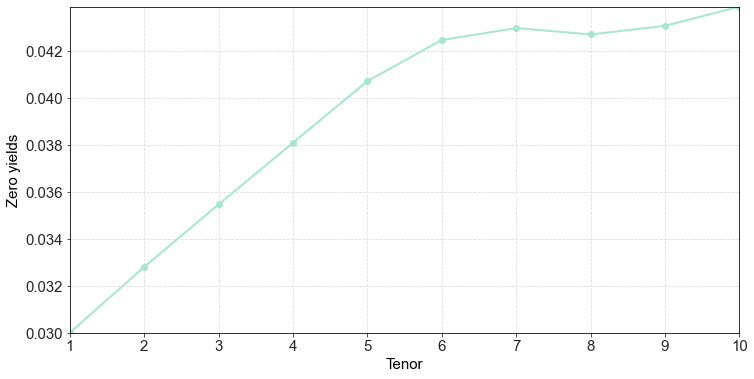

In [18]:
"""
Calculate zero yields
"""

zero_yields = discount_factors**(-1 / maturities) - 1

fig, ax = plt.subplots(figsize=(12,6)) 
plt.plot(maturities, zero_yields, marker='o');
plt.xlabel('Tenor');
plt.ylabel('Zero yields');

Assume now that we drop the bond with maturity in 5 years. Will it still be possible to use the above procedure? 

In [25]:
"""
Define price vector 
"""

prices = np.array([101.942, 103.290, 104.118, 104.460,
                   104.256, 104.552, 105.210, 105.482, 105.399])

"""
Create relevant cash flow matrix
"""

maturities = np.concatenate((np.arange(1.0, 5.0, 1.0), np.arange(6.0, 11.0, 1.0)))

term_info = list()
flow_info = list()
for maturity in maturities: 
    
    terms = np.arange(1.0, maturity + 1.0, 1.0)
    flows = np.ones_like(terms) * 5 
    flows[-1] += 100
    
    term_info.append(terms)
    flow_info.append(flows)

all_terms = reduce(np.union1d, term_info)

cash_flow_matrix = np.zeros((maturities.shape[0] , all_terms.shape[0]))

idx = 0
for terms, flows in zip(term_info, flow_info):
    
    indicator = np.in1d(all_terms, terms)

    cash_flow_matrix[idx, indicator] = flows
    
    idx += 1

In [26]:
cash_flow_matrix

array([[105.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  5., 105.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  5.,   5., 105.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  5.,   5.,   5., 105.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  5.,   5.,   5.,   5.,   5., 105.,   0.,   0.,   0.,   0.],
       [  5.,   5.,   5.,   5.,   5.,   5., 105.,   0.,   0.,   0.],
       [  5.,   5.,   5.,   5.,   5.,   5.,   5., 105.,   0.,   0.],
       [  5.,   5.,   5.,   5.,   5.,   5.,   5.,   5., 105.,   0.],
       [  5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5., 105.]])

In [29]:
cash_flow_matrix.shape

(9, 10)

In [30]:
#  the rank cannot be larger than the num. of cols or rows
np.linalg.matrix_rank(cash_flow_matrix)

9

NO, the cash flow matrix is no longer invertible and we cannot apply the above methodology! We will get an error if we try to evaluate the code `np.linalg.inv(cash_flow_matrix)`. 

### Alternatives to bootstrapping: Splines

Bootstrapping can only give us the discount factors for the payments 

### Alternatives to bootstrapping: Nelson-Siegel Svennson 

# References

## Articles

## Books

[Claus Munk (2013), "Fixed income modelling"](https://www.amazon.co.uk/Fixed-Income-Modelling-Claus-Munk/dp/0198716443)
